读数据

In [82]:
%matplotlib inline
import pandas as pd
import numpy as np
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [83]:
train_data=pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
test_data=pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

In [84]:
train_data.shape

(1460, 81)

In [85]:
test_data.shape

(1459, 80)

In [86]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [87]:
# 第一个特征是ID，它对预测房价没有帮助，因此我们将其从数据中移除。
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

In [88]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


预处理数据

In [89]:
# 将连续数值标准化
numeric_features=all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std())) 
# 标准化后，每个数值特征的均值变为0，所以我们可以固定一个0作为均值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [90]:
# 将离散数值转化为指示特征
all_features = pd.get_dummies(all_features, dummy_na=True) # dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
# get_dummies函数默认会将离散特征的每个取值都创建为布尔特征
all_features.shape

(2919, 331)

In [91]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [92]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

训练模型

In [93]:
def get_net():
    net = nn.Sequential()
    # 第一隐藏层，256个神经元，ReLU激活函数
    net.add(nn.Dense(256, activation='relu'))
    net.add(nn.Dropout(0.3))
    # 第二隐藏层，256个神经元，ReLU激活函数
    net.add(nn.Dense(256, activation='relu'))
    net.add(nn.Dropout(0.5))
    # 输出层，1个神经元，输出房价
    net.add(nn.Dense(1))
    # 初始化权重
    net.initialize(init=init.Xavier())
    return net

In [94]:
def log_rmse(net, features, labels):
    # 将小于1的值设为1，使得对数运算更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2*loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()


In [95]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    
    # 使用调整后的学习率和权重衰减
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_features is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
        
    return train_ls, test_ls


K折交叉验证

In [96]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0) # dim=0表示在第0维拼接
    return X_train, y_train, X_valid, y_valid

In [97]:
import d2lzh as d2l

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                     range(1, num_epochs + 1), valid_ls,
                     ['train', 'valid']) # semilogy函数绘制y轴对数坐标曲线
    return train_l_sum / k, valid_l_sum / k

模型选择

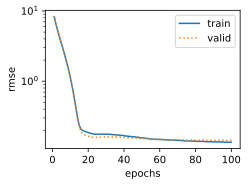

5-fold validation: average train rmse 0.133522, average valid rmse 0.148482


In [98]:
k, num_epochs, learning_rate, weight_decay, batch_size,weight_decay = 5, 100, 0.001, 0, 64,0.0005
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, learning_rate, weight_decay, batch_size)
print('%d-fold validation: average train rmse %f, average valid rmse %f' % (k, train_l, valid_l))

有时会发现一组参数的训练误差可以达到很低，但是K折交叉验证的误差却很高，这表明模型过拟合。

In [99]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, learning_rate, weight_decay, batch_size):
    net = get_net()
    train_ls,_= train(net, train_features, train_labels, None, None, num_epochs, learning_rate, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

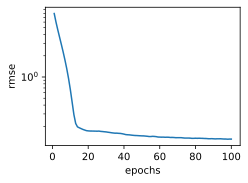

train rmse 0.131864


In [100]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs,learning_rate, weight_decay, batch_size)